In [6]:
!pip install seaborn
!pip install nltk
!pip install datasets
!pip install keras_nlp

import logging
import time
import nltk
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
import tensorflow as tf
import keras_nlp
import pathlib
import random
from tensorflow import keras
from tensorflow_text.tools.wordpiece_vocab import (
    bert_vocab_from_dataset as bert_vocab,
)

  Using cached keras_nlp-0.5.2-py3-none-any.whl (527 kB)
  Using cached tensorflow_text-2.12.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.0 MB)


  Using cached tensorflow_hub-0.13.0-py2.py3-none-any.whl (100 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 538.8 kB/s eta 0:00:00m eta 0:00:010:00:02
  Using cached jax-0.4.10.tar.gz (1.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached tensorflow_io_gcs_filesystem-0.32.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 290.7 kB/s eta 0:00:001m422.1 kB/s eta 0:00:01


  Created wheel for jax: filename=jax-0.4.10-py3-none-any.whl size=1480503 sha256=12b1e5f6fe37d49cfa0291f1ec192a3c66fd9a2694d39049b5a8c11b1d4c1792
  Stored in directory: /home/belinda/.cache/pip/wheels/f8/55/5b/9dde9a2af48db48d64b8cc3877f0670cf11c5d78de392c3f05
Successfully built jax


In [12]:
# define our parameters/hyperparameters
BATCH_SIZE = 64
EPOCHS = 10  # This should be at least 10 for convergence
MAX_SEQUENCE_LENGTH = 40
ENG_VOCAB_SIZE = 15000
LUG_VOCAB_SIZE = 15000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

In [25]:
import pandas as pd
from datasets import load_dataset

# Load the Tatoeba dataset for English and Luganda using load_dataset()
new_dataset = load_dataset('sbmaruf/forai_ml_masakhane_mafand', 'en-lug')

# Access the train, test and validation split of the dataset
train_set = new_dataset['train']
test_set = new_dataset['test']
val_set = new_dataset['validation']

# Extract the sentence pairs from the dataset split
train_pairs = [(data['source'].lower(), data['target'].lower()) for data in train_set]
test_pairs = [(data['source'].lower(), data['target'].lower()) for data in test_set]
val_pairs = [(data['source'].lower(), data['target'].lower()) for data in val_set]

random.shuffle(train_pairs)
random.shuffle(test_pairs)
random.shuffle(val_pairs)

print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

Found cached dataset forai_ml_masakhane_mafand (/home/belinda/.cache/huggingface/datasets/sbmaruf___forai_ml_masakhane_mafand/en-lug/1.0.0/5983862e8f5e8cbca281d4e2ad5a14eb519b574d59f49faad0d7f107d12a3912)


  0%|          | 0/3 [00:00<?, ?it/s]

4075 training pairs
1500 validation pairs
1500 test pairs


In [26]:
# tokenize the data
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf.data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [27]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

eng_samples = [text_pair[0] for text_pair in train_pairs]
eng_vocab = train_word_piece(eng_samples, ENG_VOCAB_SIZE, reserved_tokens)

lug_samples = [text_pair[1] for text_pair in train_pairs]
lug_vocab = train_word_piece(spa_samples, LUG_VOCAB_SIZE, reserved_tokens)

2023-05-23 08:19:27.956037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4075]
	 [[{{node Placeholder/_0}}]]
2023-05-23 08:19:41.372288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4075]
	 [[{{node Placeholder/_0}}]]


In [28]:
print("English Tokens: ", eng_vocab[100:110])
print("Luganda Tokens: ", lug_vocab[100:110])

English Tokens:  ['museveni', 'be', 'national', 'people', 'president', '##y', 'will', '##e', 'said', '##n']
Luganda Tokens:  ['bw', 'ekitongole', 'agamba', 'olw', 'ba', 'kye', 'kino', 'buli', 'lw', 'ssente']


In [29]:
eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=False
)
lug_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=lug_vocab, lowercase=False
)

In [30]:
eng_input_ex = train_pairs[0][0]
eng_tokens_ex = eng_tokenizer.tokenize(eng_input_ex)
print("English sentence: ", eng_input_ex)
print("Tokens: ", eng_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    eng_tokenizer.detokenize(eng_tokens_ex),
)

print()

lug_input_ex = train_pairs[0][1]
lug_tokens_ex = lug_tokenizer.tokenize(lug_input_ex)
print("Luganda sentence: ", lug_input_ex)
print("Tokens: ", lug_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    lug_tokenizer.detokenize(lug_tokens_ex),
)

English sentence:  with all these issues, is the judiciary delivering justice? 
Tokens:  tf.Tensor(
[  83  130  173  815   12   73   67   41 1454  183 1311   35  378 1316
   76 1019   28], shape=(17,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'with all these issues , is the judiciary delivering justice ?', shape=(), dtype=string)

Luganda sentence:  okusinziira ku nsonga zino zonna, ekitongole ekiramuzi ddala kisala emisango mu bwenkanya?
Tokens:  tf.Tensor(
[ 210   65  153  880 1074   11  101   35  362 1182  196  518  678  589
   64   77 1531   27], shape=(18,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'okusinziira ku nsonga zino zonna , ekitongole ekiramuzi ddala kisala emisango mu bwenkanya ?', shape=(), dtype=string)


In [31]:
def preprocess_batch(eng, lug):
    batch_size = tf.shape(lug)[0]

    eng = eng_tokenizer(eng)
    lug = lug_tokenizer(lug)

    # Pad `eng` to `MAX_SEQUENCE_LENGTH`.
    eng_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=eng_tokenizer.token_to_id("[PAD]"),
    )
    eng = eng_start_end_packer(eng)

    # Add special tokens (`"[START]"` and `"[END]"`) to `lug` and pad it as well.
    lug_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=lug_tokenizer.token_to_id("[START]"),
        end_value=lug_tokenizer.token_to_id("[END]"),
        pad_value=lug_tokenizer.token_to_id("[PAD]"),
    )
    lug = lug_start_end_packer(lug)

    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": lug[:, :-1],
        },
        lug[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, lug_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    lug_texts = list(lug_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, lug_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [32]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

2023-05-23 08:21:33.513210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype uint8 and shape [115964]
	 [[{{node Placeholder/_6}}]]
2023-05-23 08:21:33.513687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4075]
	 [[{{node Placeholder/_0}}]]


inputs["encoder_inputs"].shape: (64, 40)
inputs["decoder_inputs"].shape: (64, 40)
targets.shape: (64, 40)


2023-05-23 08:21:34.204348: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [33]:
## Building the model

# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ENG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=LUG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(LUG_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="transformer",
)

In [34]:
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Train the model and store the history
history = transformer.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding_2  (None, None, 256)   3850240     ['encoder_inputs[0][0]']         
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_1 (Transfo  (None, None, 256)   1315072     ['token_and_position_em

2023-05-23 08:21:50.915892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4075]
	 [[{{node Placeholder/_0}}]]
2023-05-23 08:21:50.916597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype uint8 and shape [134004]
	 [[{{node Placeholder/_7}}]]


64/64 [==============================] - ETA: 0s - loss: 6.7044 - accuracy: 0.0722

2023-05-23 08:23:29.149661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1500]
	 [[{{node Placeholder/_1}}]]
2023-05-23 08:23:29.154386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1500]
	 [[{{node Placeholder/_0}}]]


64/64 [==============================] - 118s 2s/step - loss: 6.7044 - accuracy: 0.0722 - val_loss: 5.9435 - val_accuracy: 0.0951
Epoch 2/10
64/64 [==============================] - 120s 2s/step - loss: 5.6570 - accuracy: 0.1405 - val_loss: 5.3381 - val_accuracy: 0.1614
Epoch 3/10
64/64 [==============================] - 109s 2s/step - loss: 5.1715 - accuracy: 0.1725 - val_loss: 5.0983 - val_accuracy: 0.1773
Epoch 4/10
64/64 [==============================] - 112s 2s/step - loss: 4.8786 - accuracy: 0.1932 - val_loss: 4.9046 - val_accuracy: 0.1862
Epoch 5/10
64/64 [==============================] - 121s 2s/step - loss: 4.6516 - accuracy: 0.2057 - val_loss: 4.7465 - val_accuracy: 0.1920
Epoch 6/10
64/64 [==============================] - 120s 2s/step - loss: 4.4778 - accuracy: 0.2139 - val_loss: 4.6439 - val_accuracy: 0.1957
Epoch 7/10
64/64 [==============================] - 126s 2s/step - loss: 4.3471 - accuracy: 0.2191 - val_loss: 4.6531 - val_accuracy: 0.1922
Epoch 8/10
64/64 [======

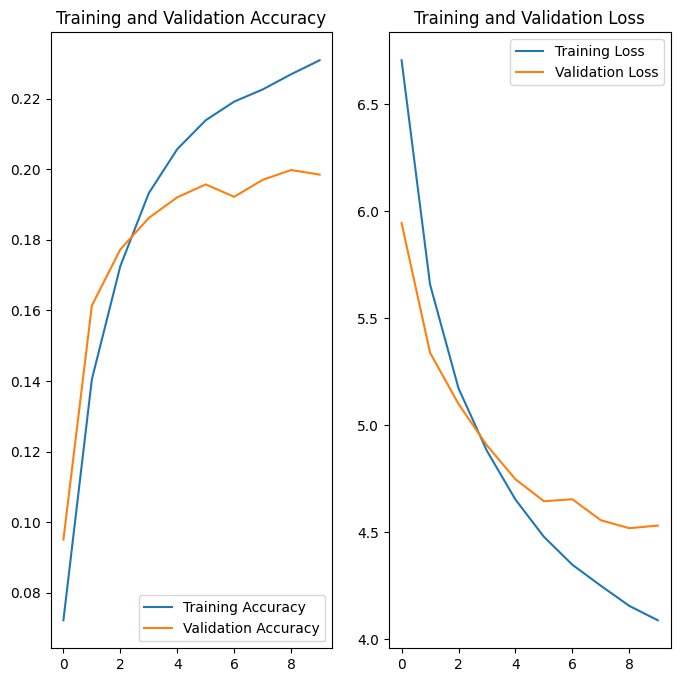

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()